# Text Analysis - Karl Merisalu
CLEAN (and efficient!) VERSION

### 1) To be run once to set up the environment

In [42]:
# For data and matrix manipulation
import pandas as pd
import numpy as np

# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import cufflinks as cf
import plotly.graph_objs as go
from plotly.plotly import iplot
%matplotlib inline
import time
import pylab as pl
from IPython import display

# For string manipulation
import re 
import string

# For text pre-processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# For assigning sentiment polarity scores
from textblob import TextBlob

# For extracting features -- i.e. the document-term matrix
from sklearn.feature_extraction.text import CountVectorizer

# For splitting the data into a training and a testing set
from sklearn.model_selection import train_test_split

# For using Naive Bayes - the typical basic machine learning algorithm of choice for Text analytics
from sklearn.naive_bayes import MultinomialNB

# For evaluating our machine learning model 
from sklearn.metrics import accuracy_score, classification_report


# Necessary dependencies from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import time
import datetime
dfrolling = pd.DataFrame()

vector = CountVectorizer(max_features= 10000 , min_df=0.01, ngram_range= (1,1))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
# defining method for data cleaning

def clean_text(sample_text):
    
    # Given a sample text (as a string), we first substitute a select few sybmols with white space
    sample_text = re.sub(r'[#|@|-|?|!]',r' ',sample_text)
    
    # We then strip extra white space
    sample_text = re.sub('\s+',' ', sample_text)
    
    # Then change everything to lower case
    sample_text = sample_text.lower()
    
    # Then lemmatize our words -- note,  stemming was deemed too crude here, and therefore not chosen
    sample_text = WordNetLemmatizer().lemmatize(sample_text)
    
    
    # Now that we transformed our text, we need to tokenize it. Let's treat each word as a token.
    words = word_tokenize(sample_text)
    
    # As we now have a list of words,  we can go ahead and find and remove those words that also belong to the 
    # stopwords list from the NLTK corpus
    words = [w for w in words if w not in stopwords.words('english')]
    
    # We then proceed to joining those list of words, back to 'free text'  or string format
    text = ' '.join(words)
    
    return text

In [44]:
# Import the Twython class
from twython import Twython
import json

# Load credentials from json file
with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

# Instantiate an object
python_tweets = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])

In [45]:
# Create our query
query = {'q': '@BorisJohnson', # What is the search term?
        'count': 100,
        'result_type': 'recent',
        'lang': 'en',
        }



### 2) Action starts here

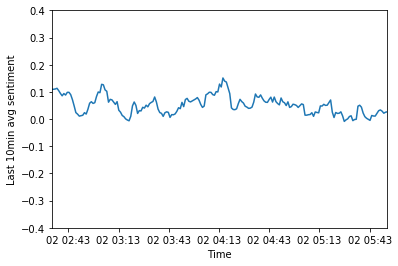

<Figure size 432x288 with 0 Axes>

In [46]:
# Search tweets
dict_ = {'user': [], 'date': [], 'text': [], 'favorite_count': []}
for status in python_tweets.search(**query)['statuses']:
    dict_['user'].append(status['user']['screen_name'])
    dict_['date'].append(status['created_at'])
    dict_['text'].append(status['text'])
    dict_['favorite_count'].append(status['favorite_count'])

# Structure data in a pandas DataFrame for easier manipulation
df = pd.DataFrame(dict_)

# Running the same algorithm for another 10x in order to get a better sample
# Bsed on experience, 15 iterations with 60sec sleep gets ~1k unique tweets

for i in range(210):
    dict_ = {'user': [], 'date': [], 'text': [], 'favorite_count': []}
    for status in python_tweets.search(**query)['statuses']:
        dict_['user'].append(status['user']['screen_name'])
        dict_['date'].append(status['created_at'])
        dict_['text'].append(status['text'])
        dict_['favorite_count'].append(status['favorite_count'])

    # Structure data in a pandas DataFrame for easier manipulation
    df2 = pd.DataFrame(dict_)
    df = pd.concat([df,df2], ignore_index=True) # adding newly pulled results to the existing dataset
    df.sort_values(by='text', inplace=True, ascending=False)
    df.drop_duplicates(subset = 'text', inplace = True) # removing duplicates
       
    tweets = df[['text','date']]
    tweets['date'] = pd.to_datetime(tweets['date'], format = '%a %b %d %H:%M:%S +0000 %Y')
    tweets.set_index('date', inplace = True)
    tweets = tweets.sort_index(ascending=0)
    avg15min = tweets[datetime.datetime.now():(datetime.datetime.now() - datetime.timedelta(minutes=75))] #because Twitter
    # only gives data with 1h delay for standard developer...
    
    # We can quickly apply the above function by using the 'apply' and 'lambda' functions as so
    avg15min = avg15min['text'].apply(lambda x: clean_text(x))
    
    # We use the fit_transform() function to apply the above to our tweets
    bag_of_words = vector.fit_transform(avg15min)
    
    sentiments = []
    
    for tweet in avg15min:
        analysis = TextBlob(tweet)
        sentiments.append(analysis.sentiment.polarity)

    # We add that list to a new dataframe of our tweets
    avg15min = pd.DataFrame(avg15min)

    avg15min['sentiments'] = sentiments
    
    dfrolling = dfrolling.append({'Time': datetime.datetime.now(), 'avg15min': avg15min["sentiments"].mean()}, ignore_index=True)
    
    
    axes = plt.gca()
    axes.set_xlim([(datetime.datetime.now() - datetime.timedelta(minutes=200)),datetime.datetime.now()])
    axes.set_ylim([-0.4,0.4])
    
    pl.plot(dfrolling['Time'], dfrolling['avg15min'], label= "Average 15min sentiment")
    pl.xlabel('Time')
    pl.ylabel('Last 10min avg sentiment')
        
    display.clear_output(wait=True)
    display.display(pl.gcf())
    pl.gcf().clear()
    
    time.sleep(60) # waiting for 3 sec before another pull request
    
df.to_csv('BorisJohnsonOvernight.csv', encoding='utf-8', index=False) # using this to save dataset to disk in the end